#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import model_utils
from importlib import reload

In [2]:
plt.style.use('./styles.txt')

#### Index

# Introduction

## Data Loading

In [3]:
df = utils.LoadDf()

In [4]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


## Preprocessing

This will follow the same process as in previous models, however we will not have to convert the numeric columns as Decision Trees are insensitive to outliers in the data.

In [5]:
df = utils.BasicCategoricalPreprocessing(df)

In [6]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.10,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.00,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0
2,1992,2,0.25,A,40.775000,-74.854160,6.385714,1.585714,67.185714,1.394286,...,0,0,0,0,0,0,0,0,0,0
3,1992,3,1.91,B,31.018500,-83.297300,14.457143,11.828571,78.957143,4.685714,...,0,0,0,0,0,0,0,0,0,0
4,1992,3,2.00,B,30.728900,-87.238100,14.428571,10.985714,79.971429,0.188571,...,0,0,0,0,0,0,0,0,0,0


## Modelling

### Baseline Model

In [7]:
from sklearn.model_selection import train_test_split

X, y = model_utils.GenerateXy(df)

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [8]:
from sklearn.tree import DecisionTreeClassifier

base_DT_model = DecisionTreeClassifier(random_state=1)
base_DT_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [9]:
print(f"The TRAIN classification accuracy is:  {base_DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {base_DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.9997477613822676
The TEST classification accuracy is:  0.3435345552379351


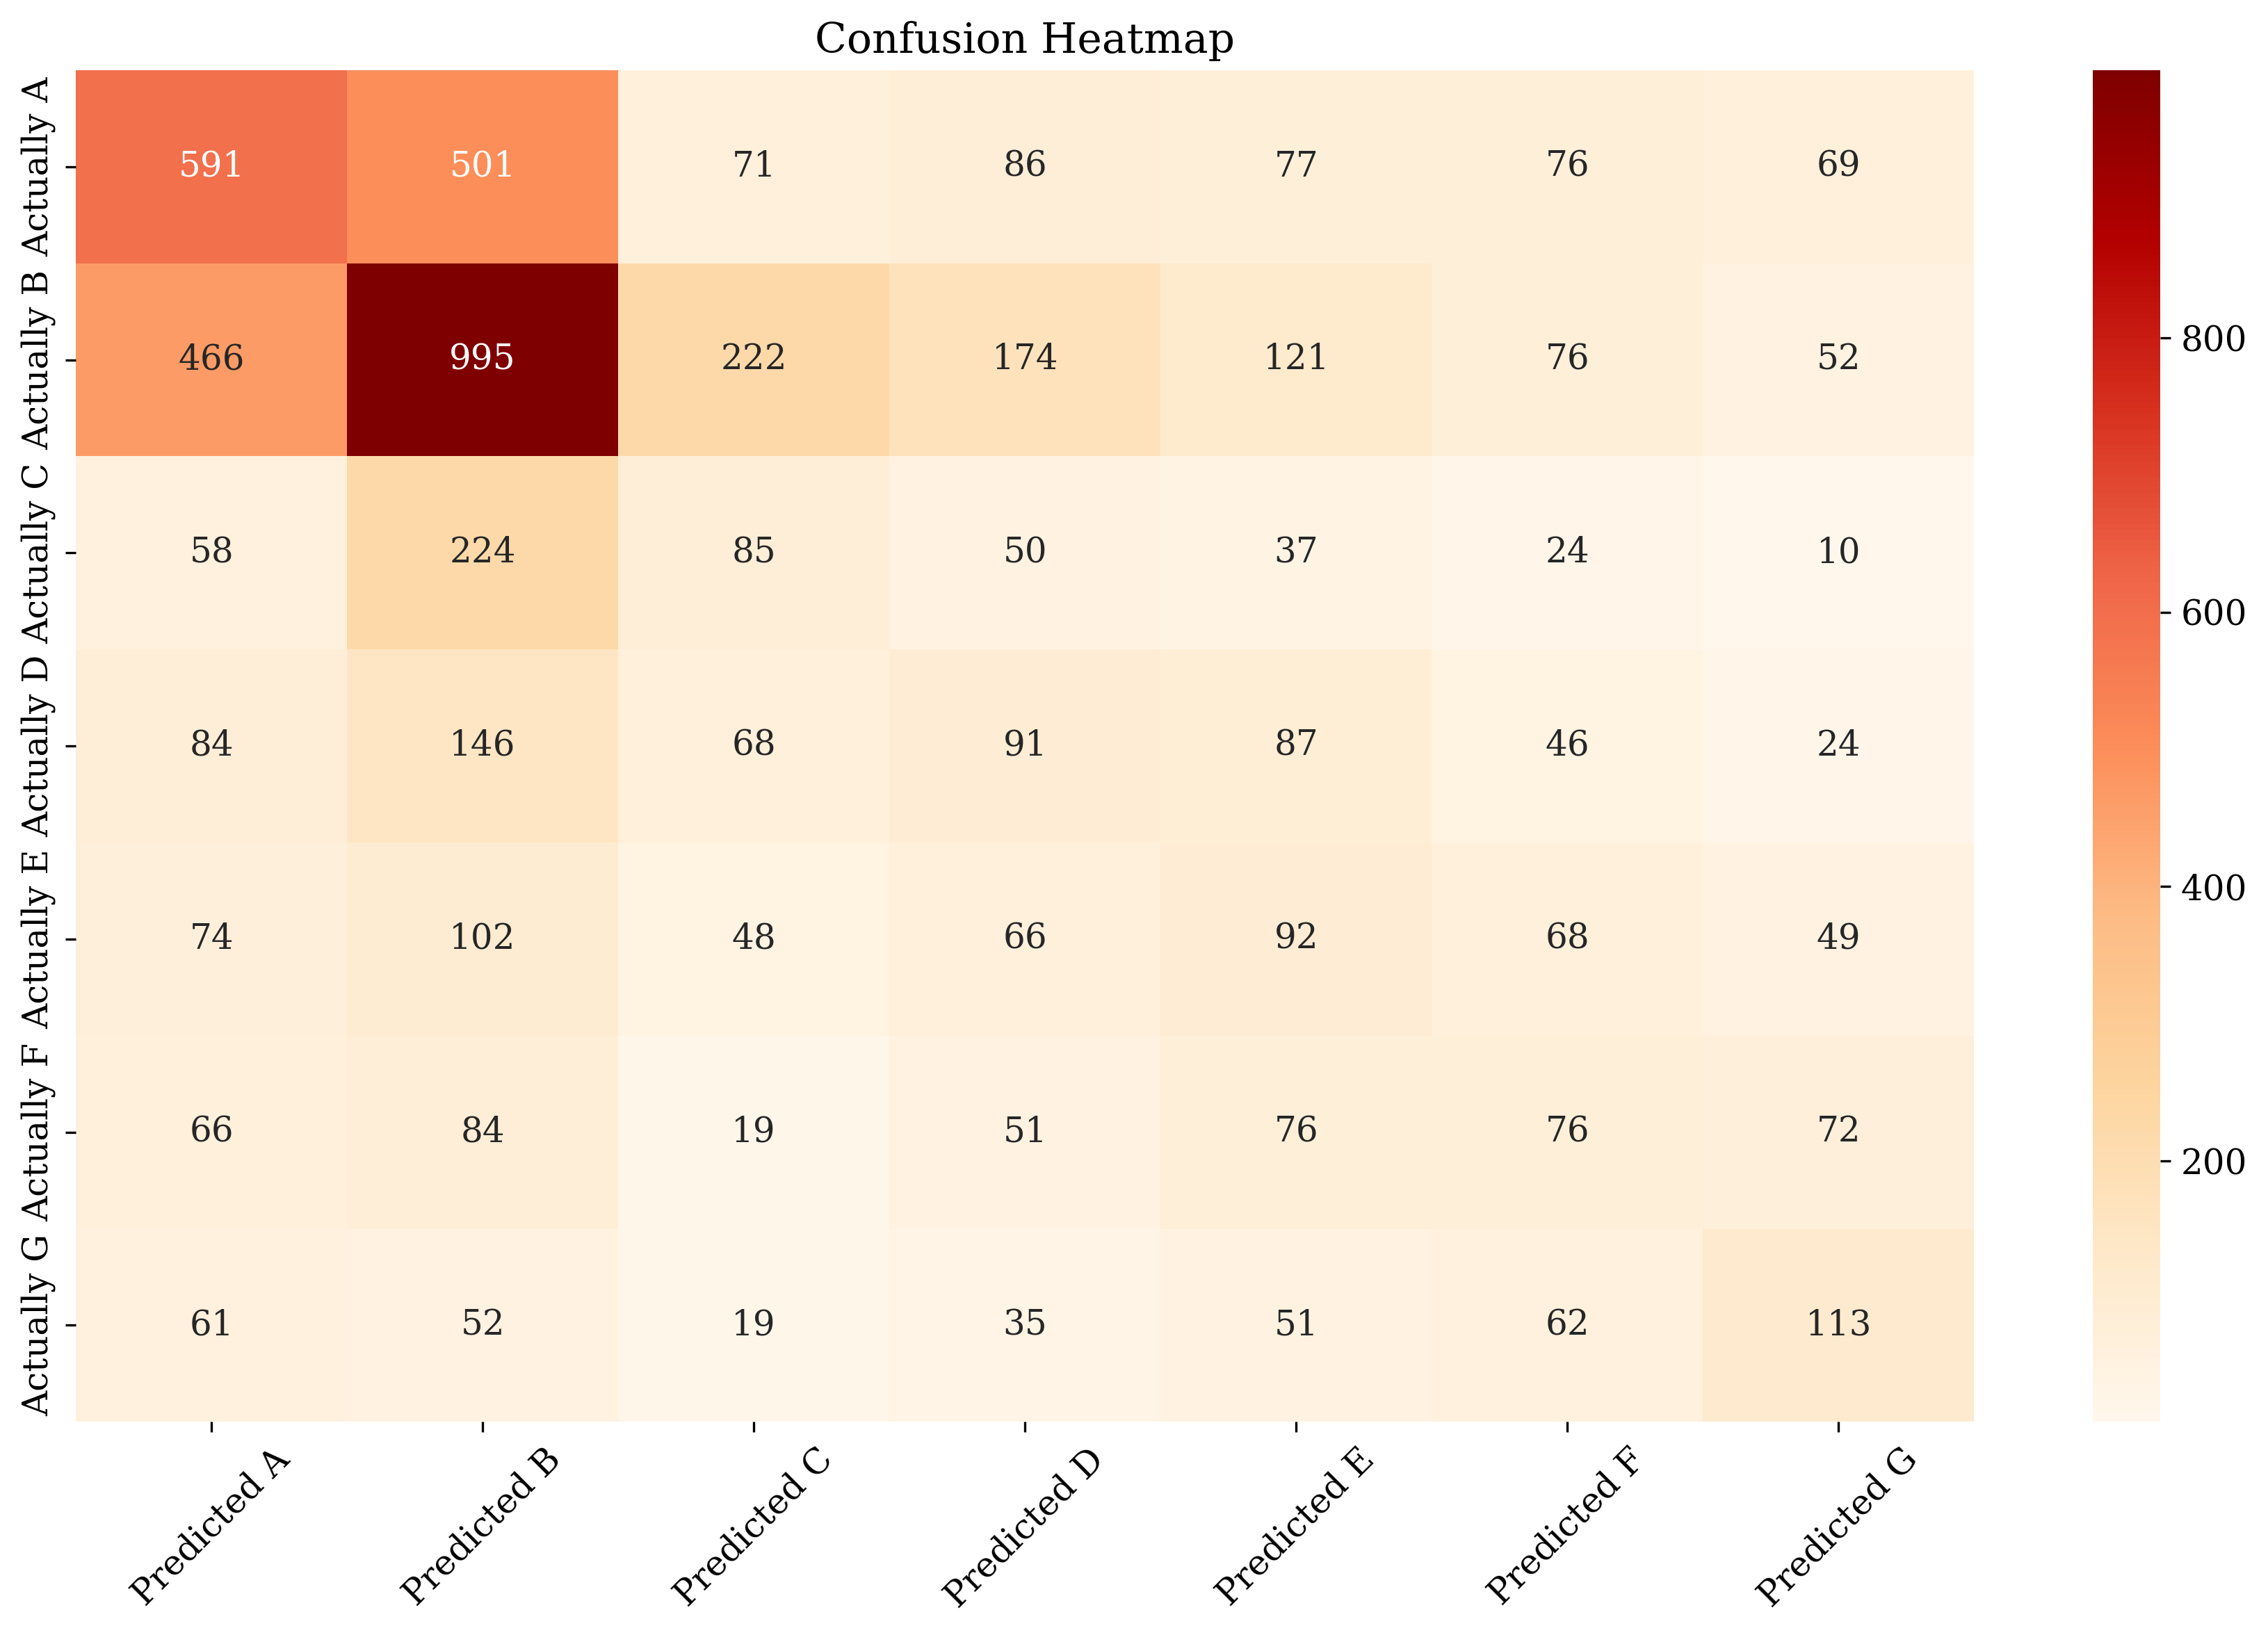

              precision    recall  f1-score   support

           A       0.42      0.40      0.41      1471
           B       0.47      0.47      0.47      2106
           C       0.16      0.17      0.17       488
           D       0.16      0.17      0.17       546
           E       0.17      0.18      0.18       499
           F       0.18      0.17      0.17       444
           G       0.29      0.29      0.29       393

    accuracy                           0.34      5947
   macro avg       0.27      0.27      0.27      5947
weighted avg       0.35      0.34      0.35      5947



In [10]:
model_utils.PlotConfusionMatrix(base_DT_model, X_test, y_test)

In [11]:
utils.count_percentage_df(y_train).sort_index()

,Count,Percentage of Total
A,5884,0.247362
B,8423,0.354101
C,1953,0.082104
D,2182,0.091731
E,1995,0.083869
F,1778,0.074747
G,1572,0.066087


Given the uneven distribution of `FIRE_SIZE_CLASS`, we see that the model is actually worse than a dummy model that always predicts class B. There are obviously improvements to be made, such as hyperparameter optimisation, but before this we will increase the number of samples using SMOTE, a method that we have used previously. As we have mentioned, the purpose of SMOTE is to increase the underrepresented classes within the data such that a model may improve the predictions it makes for these.

### Upsampling with SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [13]:
utils.count_percentage_df(y_train_sm)

,Count,Percentage of Total
B,8423,0.142857
A,8423,0.142857
D,8423,0.142857
E,8423,0.142857
G,8423,0.142857
C,8423,0.142857
F,8423,0.142857


In [15]:
DT_model = DecisionTreeClassifier(random_state=1)
DT_model.fit(X_train_sm, y_train_sm)

DT_model.score(X_test, y_test)

0.3211703379855389

Unfortunately the model accuracy has now decreased even more than previously. Hopefully, however, hyperparameter optimisation will improve the accuracy of the model.

## Model Optimisation

### Hyperparameter Optimisation

From the results above we realise that while the train scores were very high, the test scores were very low. This is indicative of the decision tree overfitting to the data - a problem which Decision Trees tend to be prone to if not given the correct hyperparameters. We will therefore try to improve on the hyperparameters starting with depth.

In [20]:
X_rem, X_test, y_rem, y_test = \
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

X_train, X_validation, y_train, y_validation = \
train_test_split(X_rem, y_rem, test_size=0.2, stratify=y_rem, random_state=1)

In [22]:
depths = list(range(1, 51, 1))
train_accuracies = []
validation_accuracies = []

for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    # Create model
    DT_model = DecisionTreeClassifier(max_depth=depth)
    DT_model.fit(X_train, y_train)
    
    # Append scores
    train_accuracies.append(DT_model.score(X_train, y_train))
    validation_accuracies.append(DT_model.score(X_validation, y_validation))

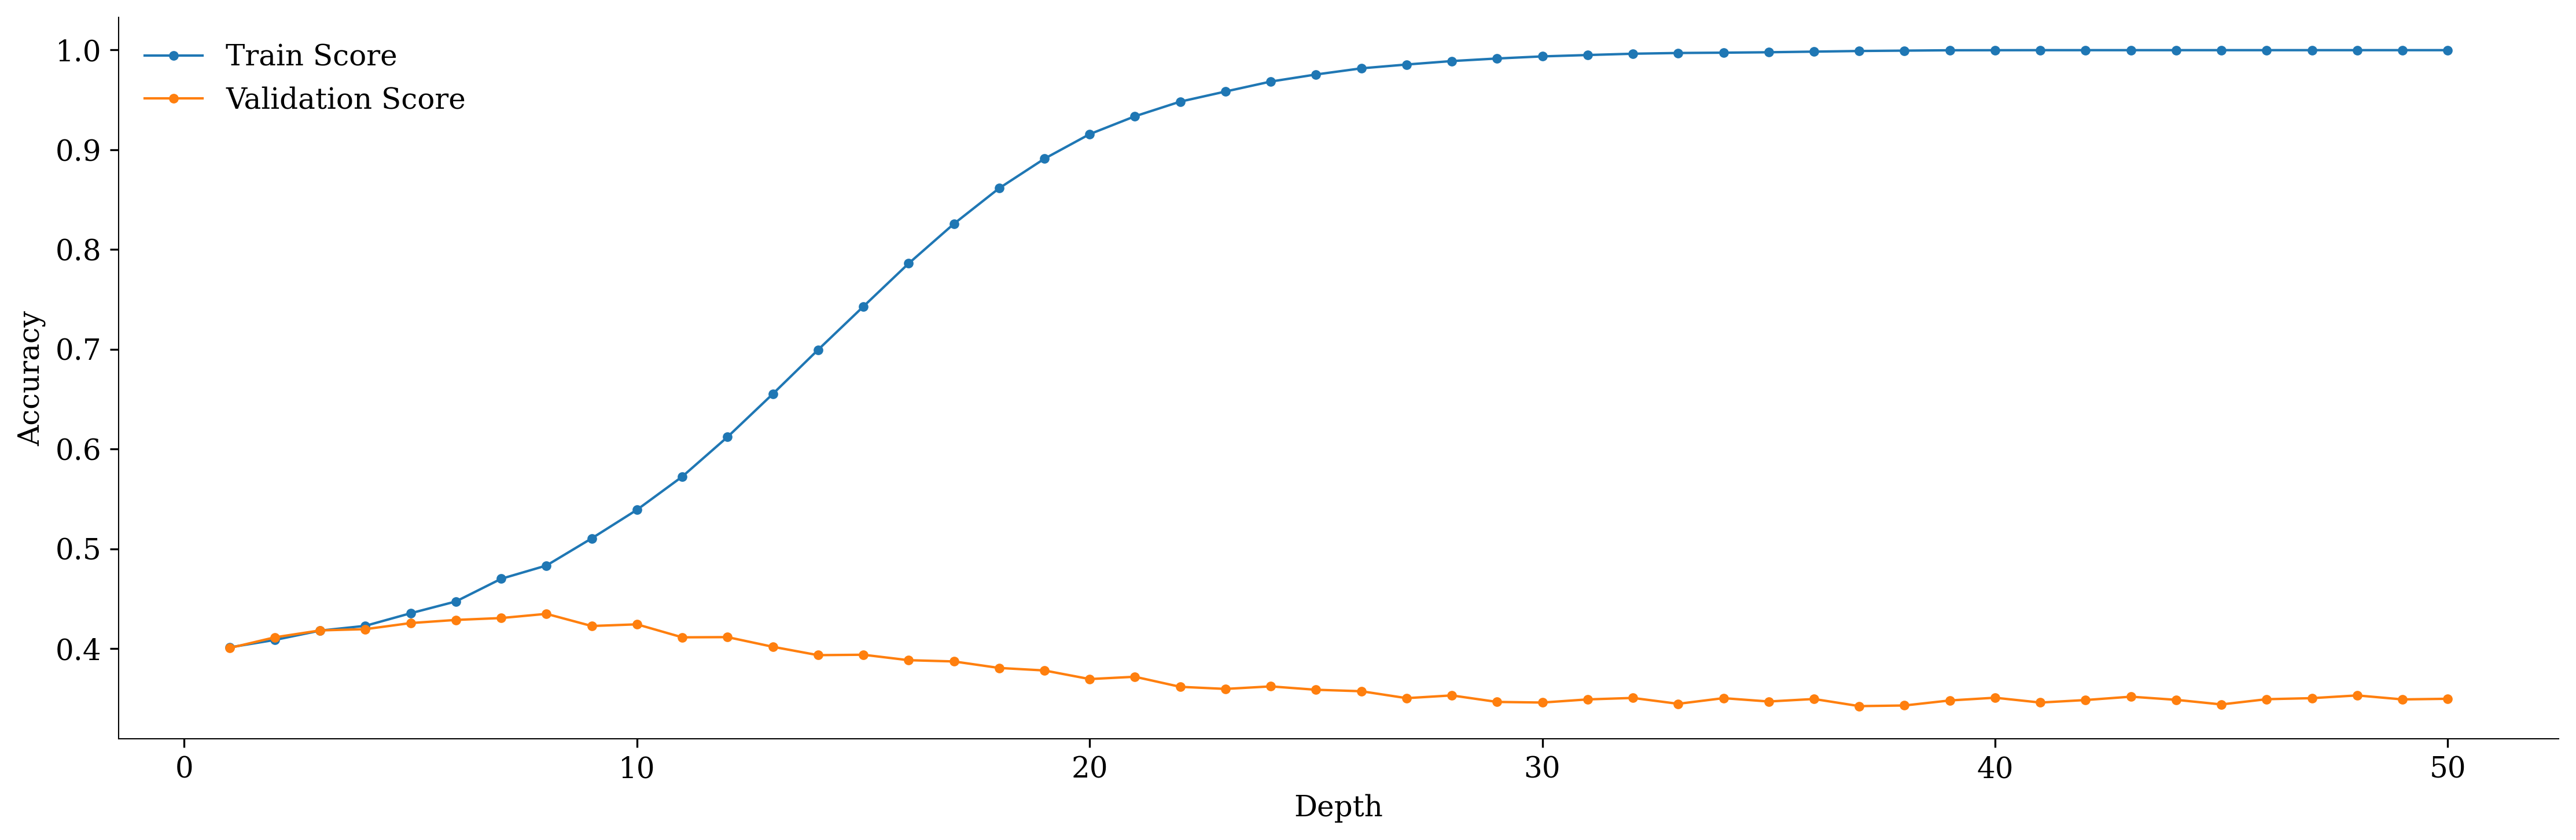

In [23]:
model_utils.PlotTrainTest(depths, 'Depth', train_accuracies, validation_accuracies, validation=True)

In [24]:
best_d = depths[np.argmax(validation_accuracies)]
print(f'The depth with the highest validation accuracy is: {best_d}')

The depth with the highest validation accuracy is: 8


In [28]:
DT_model = DecisionTreeClassifier(max_depth=8)
DT_model.fit(X_train, y_train)

DT_model.score(X_test, y_test)

0.4242475197578611

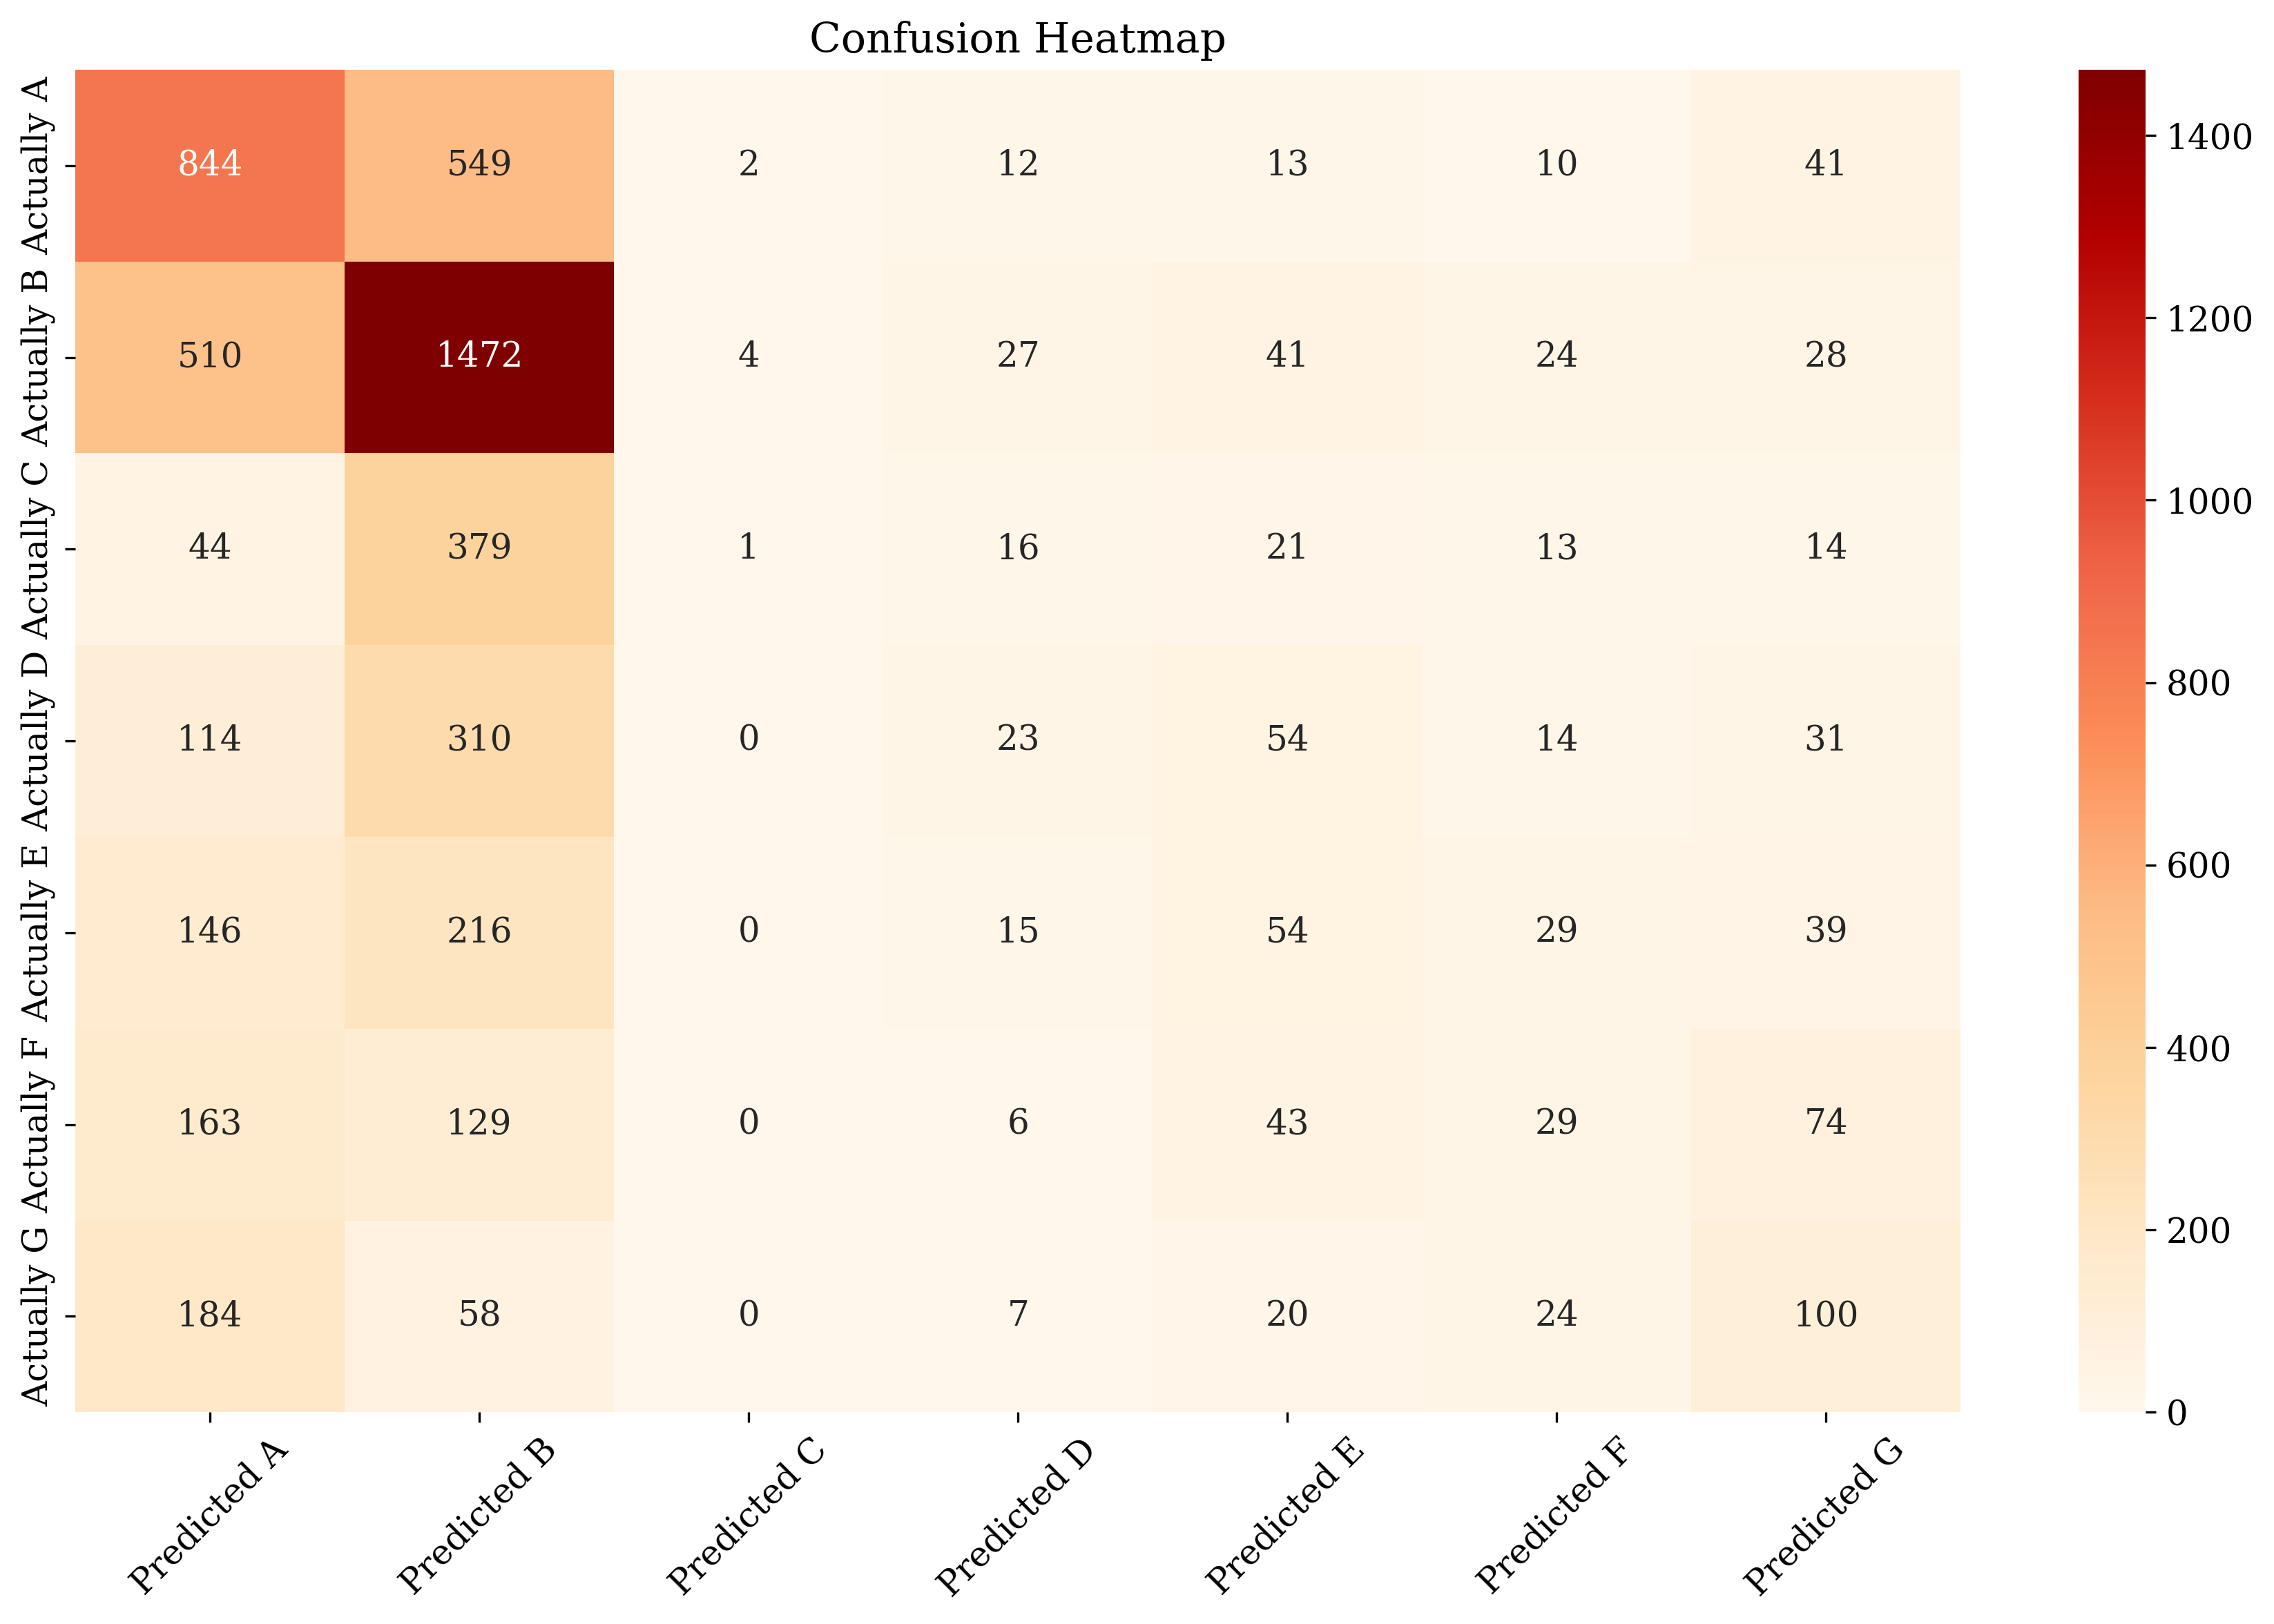

              precision    recall  f1-score   support

           A       0.42      0.57      0.49      1471
           B       0.47      0.70      0.56      2106
           C       0.14      0.00      0.00       488
           D       0.22      0.04      0.07       546
           E       0.22      0.11      0.14       499
           F       0.20      0.07      0.10       444
           G       0.31      0.25      0.28       393

    accuracy                           0.42      5947
   macro avg       0.28      0.25      0.24      5947
weighted avg       0.36      0.42      0.36      5947



In [29]:
model_utils.PlotConfusionMatrix(DT_model, X_test, y_test)

As we can see, the optimum depth - according to the validation scores - is a depth of 8. We see that after that point the model overfits and underperforms when classifying. We can further validate the optimum depth by using cross-validation, as this will reduce the data leakage that occurs when performing this hyperparameter optimisation. 

In [25]:
from sklearn.model_selection import cross_val_score

# Generate depths
depths = list(range(1, 51))

# Initialise list
cross_validation_scores = []

# Iteratively create models
for depth in depths:
    print(f'Fitting model: {depth}', end='\r')
    DT_model = DecisionTreeClassifier(max_depth=depth)
    cv_score = np.mean(cross_val_score(DT_model, X_rem, y_rem, cv = 2))
    cross_validation_scores.append(cv_score)

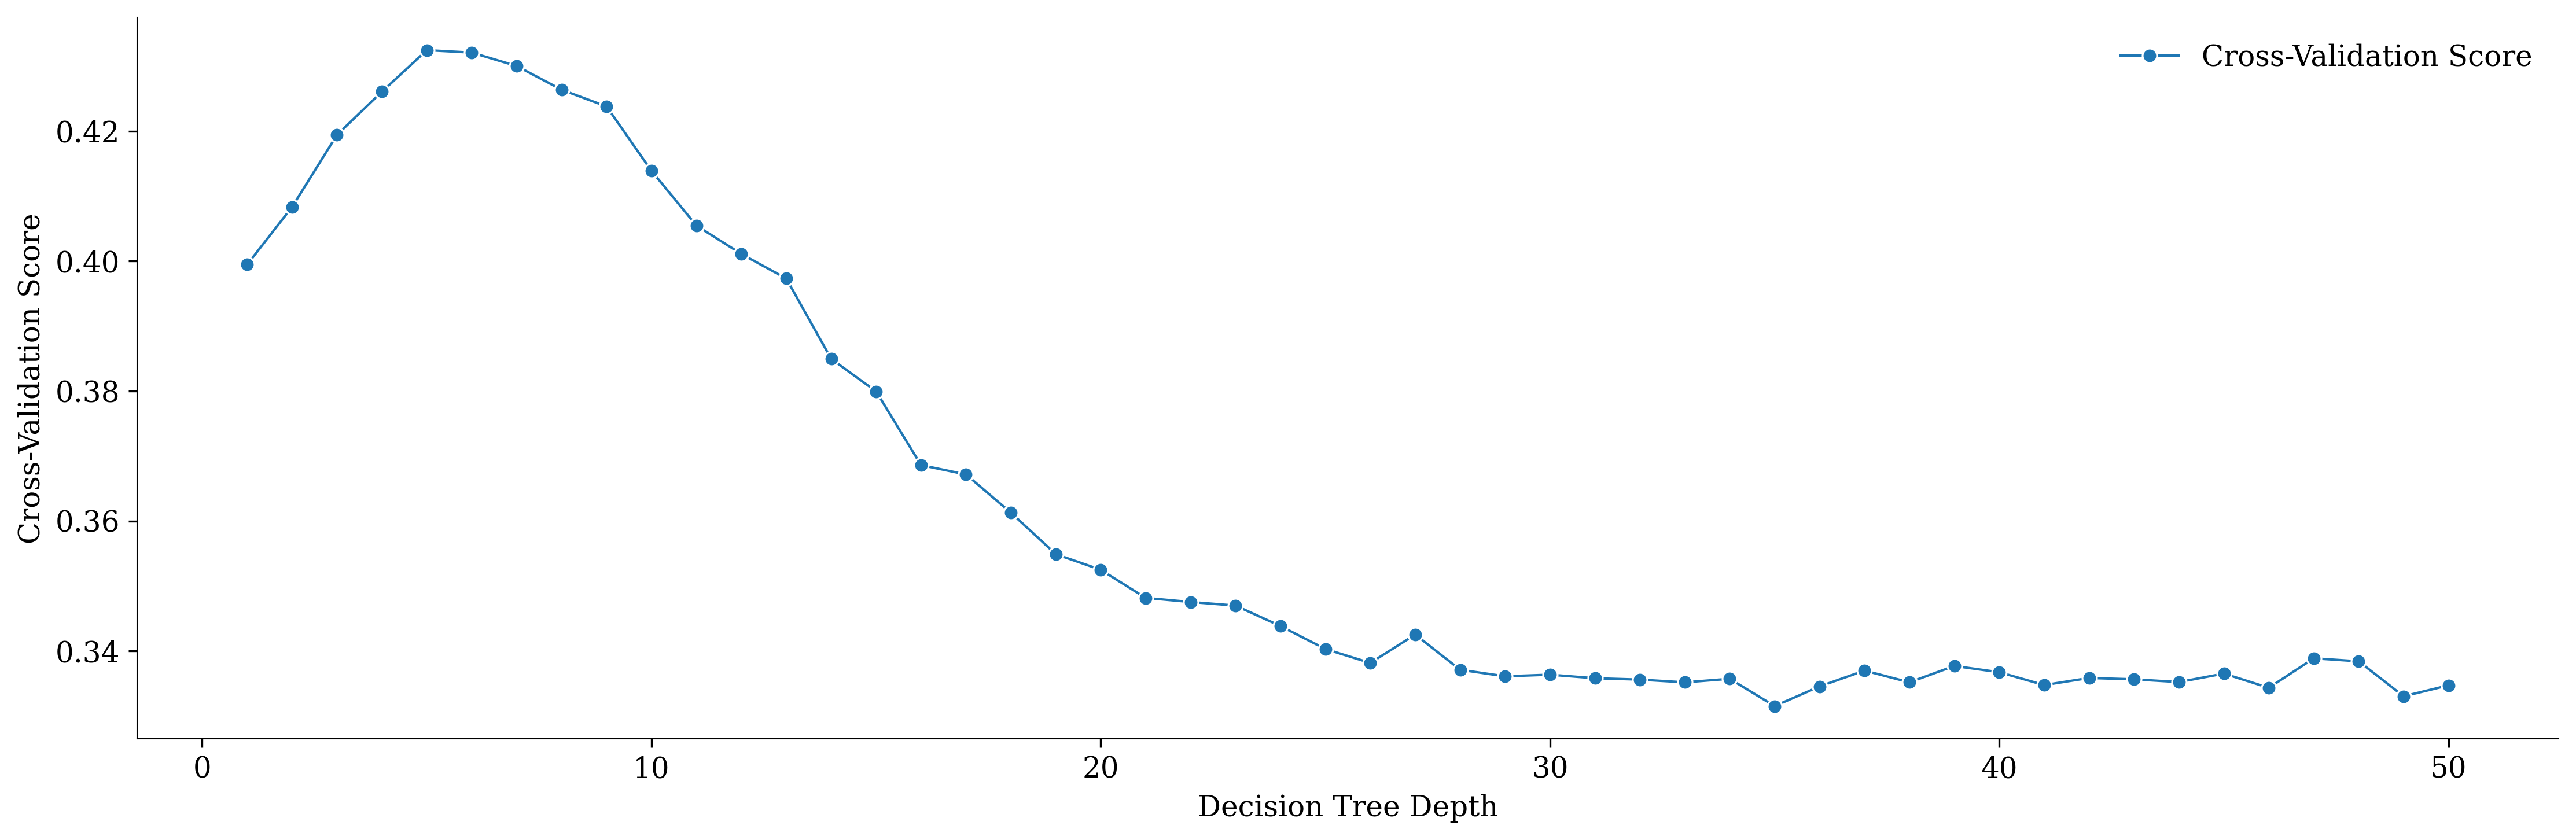

In [26]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=depths, y=cross_validation_scores, marker='o', label='Cross-Validation Score')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.show()

In [27]:
optimum_depth = depths[np.argmax(cross_validation_scores)]
print(f'The optimum depth for the decision tree model is {optimum_depth}')

The optimum depth for the decision tree model is 5


Having completed the cross validation we see that the optimum depth calculated was 5. Using this we can create a further model and calculate the accuracy of the model.

In [30]:
DT_model = DecisionTreeClassifier(max_depth=5)
DT_model.fit(X_rem, y_rem)

print(f'The test accuracy of the model with a max depth of 6 is: {DT_model.score(X_test, y_test):.2f}')

The test accuracy of the model with a max depth of 6 is: 0.42


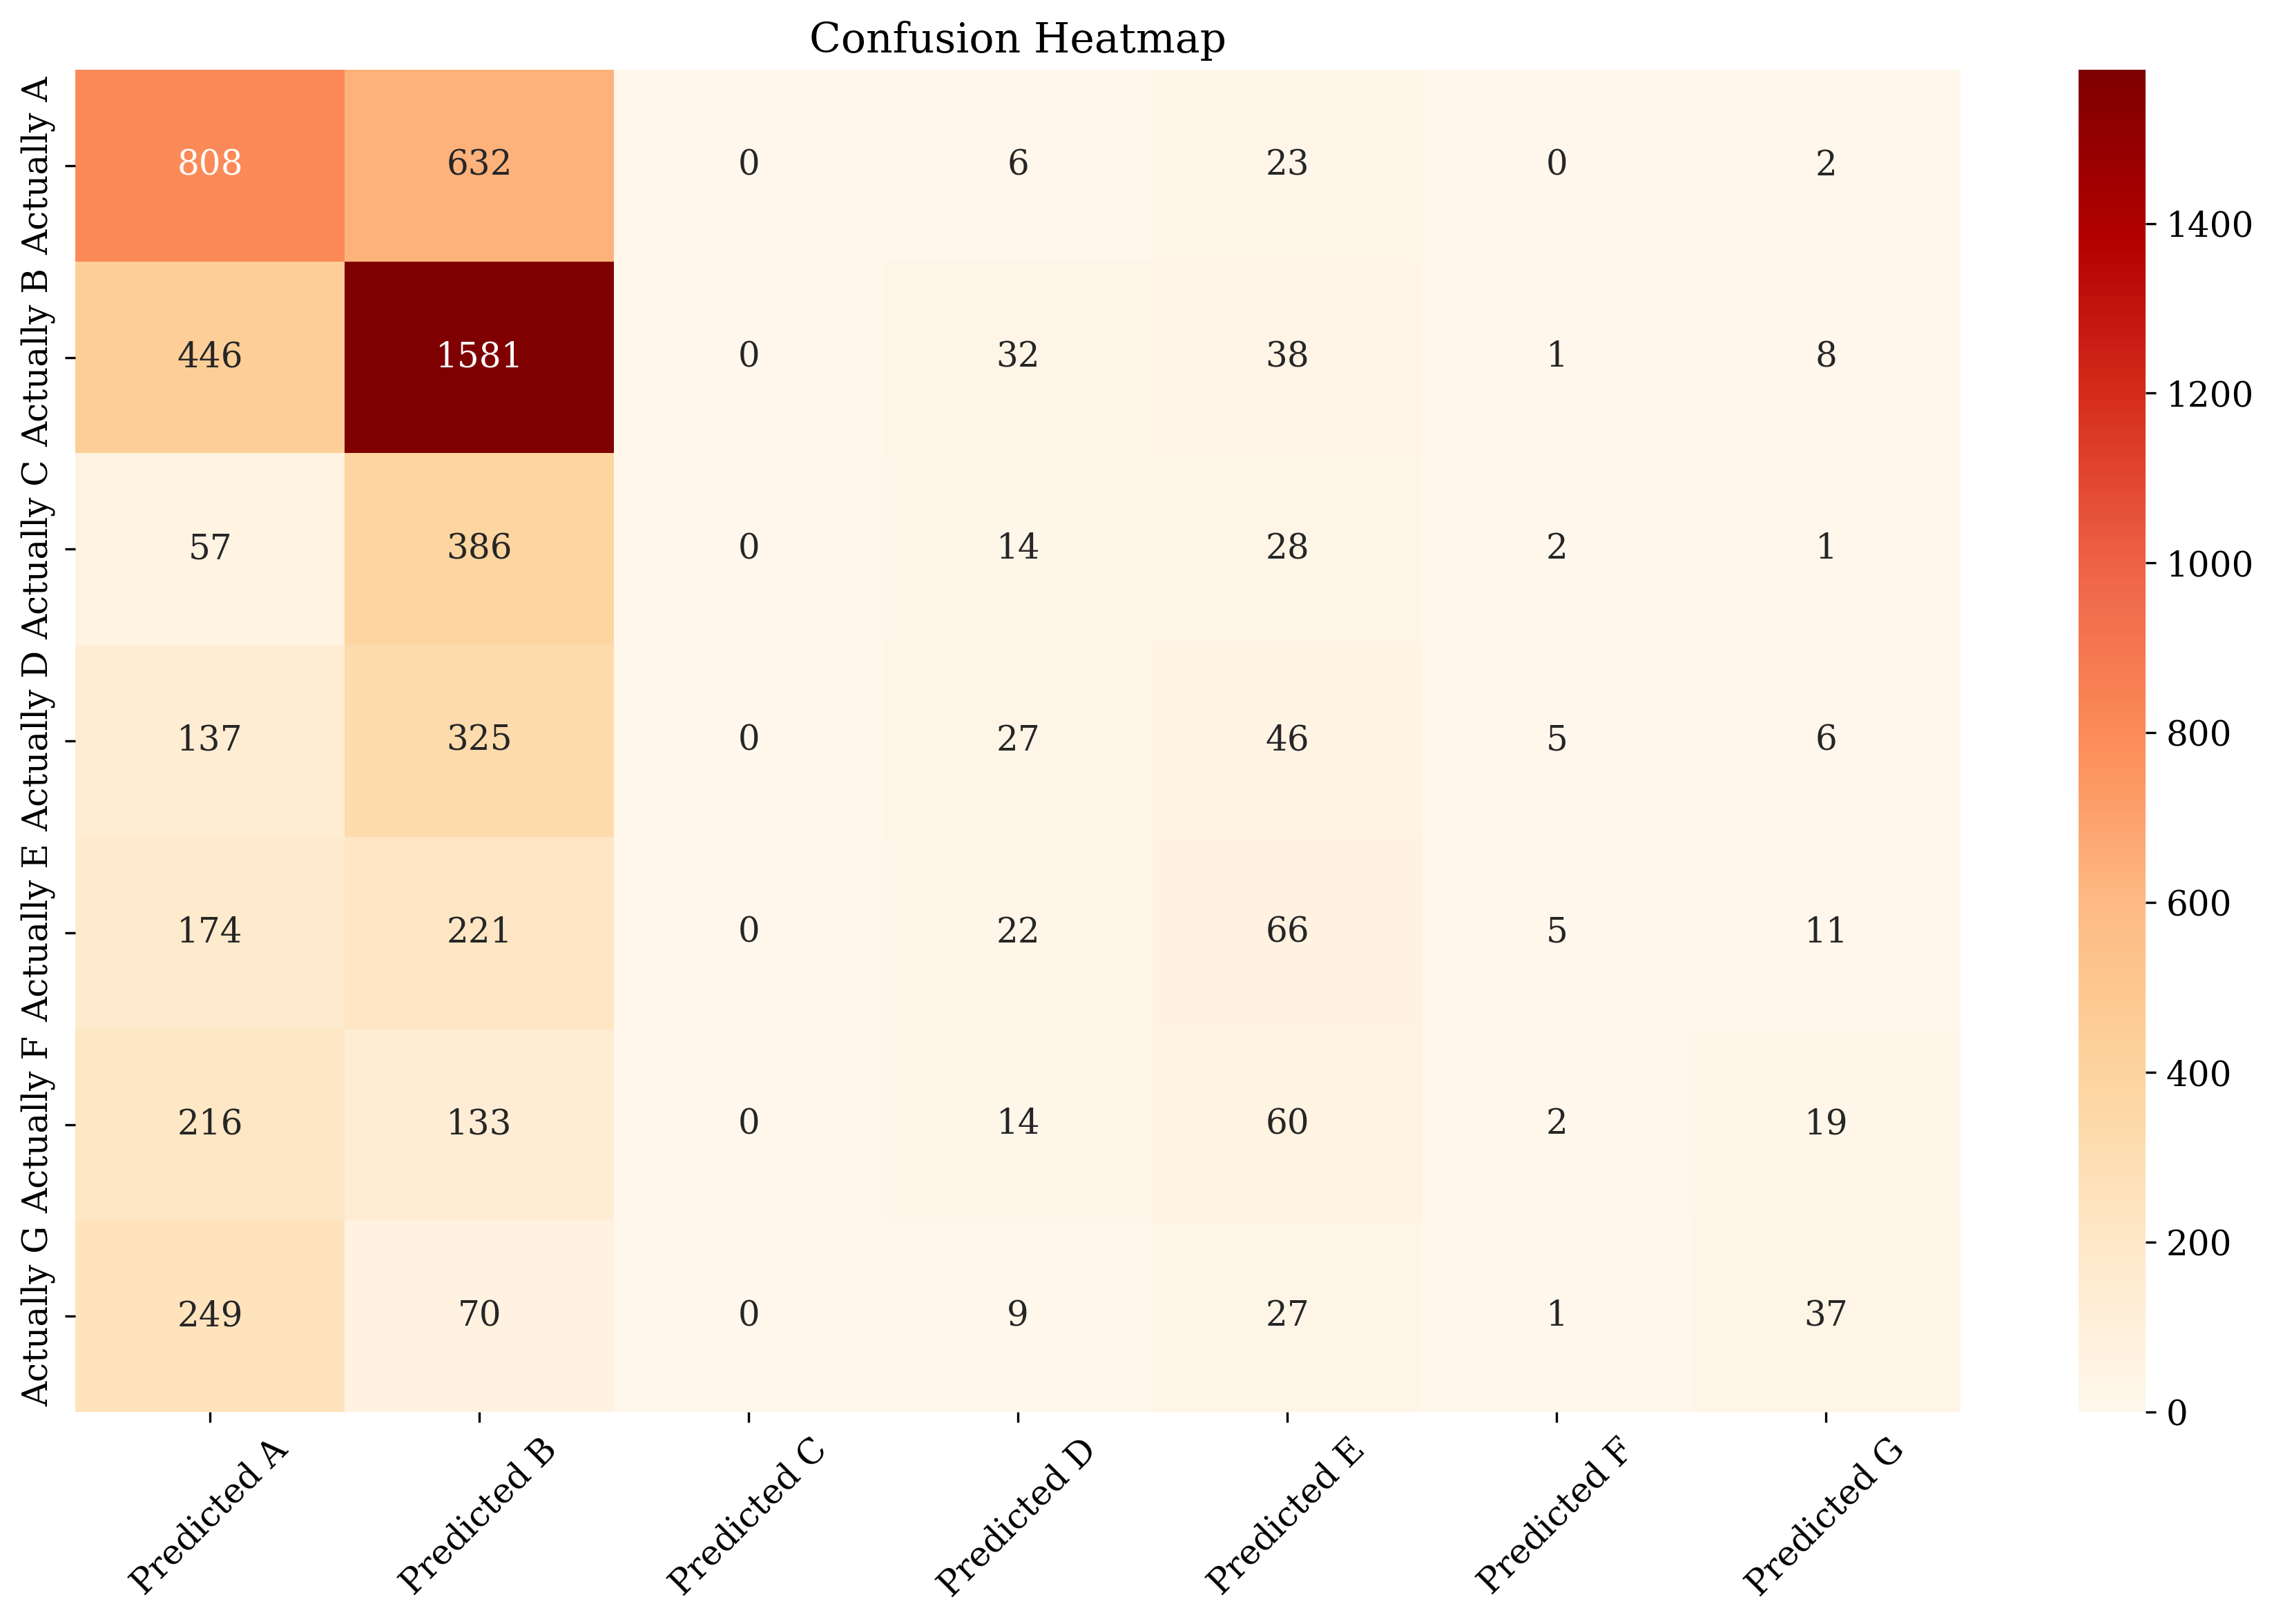

              precision    recall  f1-score   support

           A       0.39      0.55      0.45      1471
           B       0.47      0.75      0.58      2106
           C       0.00      0.00      0.00       488
           D       0.22      0.05      0.08       546
           E       0.23      0.13      0.17       499
           F       0.12      0.00      0.01       444
           G       0.44      0.09      0.16       393

    accuracy                           0.42      5947
   macro avg       0.27      0.23      0.21      5947
weighted avg       0.34      0.42      0.35      5947



/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model_utils.PlotConfusionMatrix(DT_model, X_test, y_test)

### Hyperparameter Optimisation with Grid Search

In [32]:
from tempfile import mkdtemp
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [{'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
               'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
               'model__criterion': ['gini', 'entropy'],
               'model__splitter': ['best', 'random'],
               'model__min_samples_leaf': list(range(2, 20, 2))}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
fittedgrid = grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


In [33]:
fittedgrid.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__min_samples_leaf': 10,
 'model__splitter': 'best',
 'reduce_dim': None}

In [34]:
fittedgrid.best_estimator_.score(X_test, y_test)

0.42727425592735835

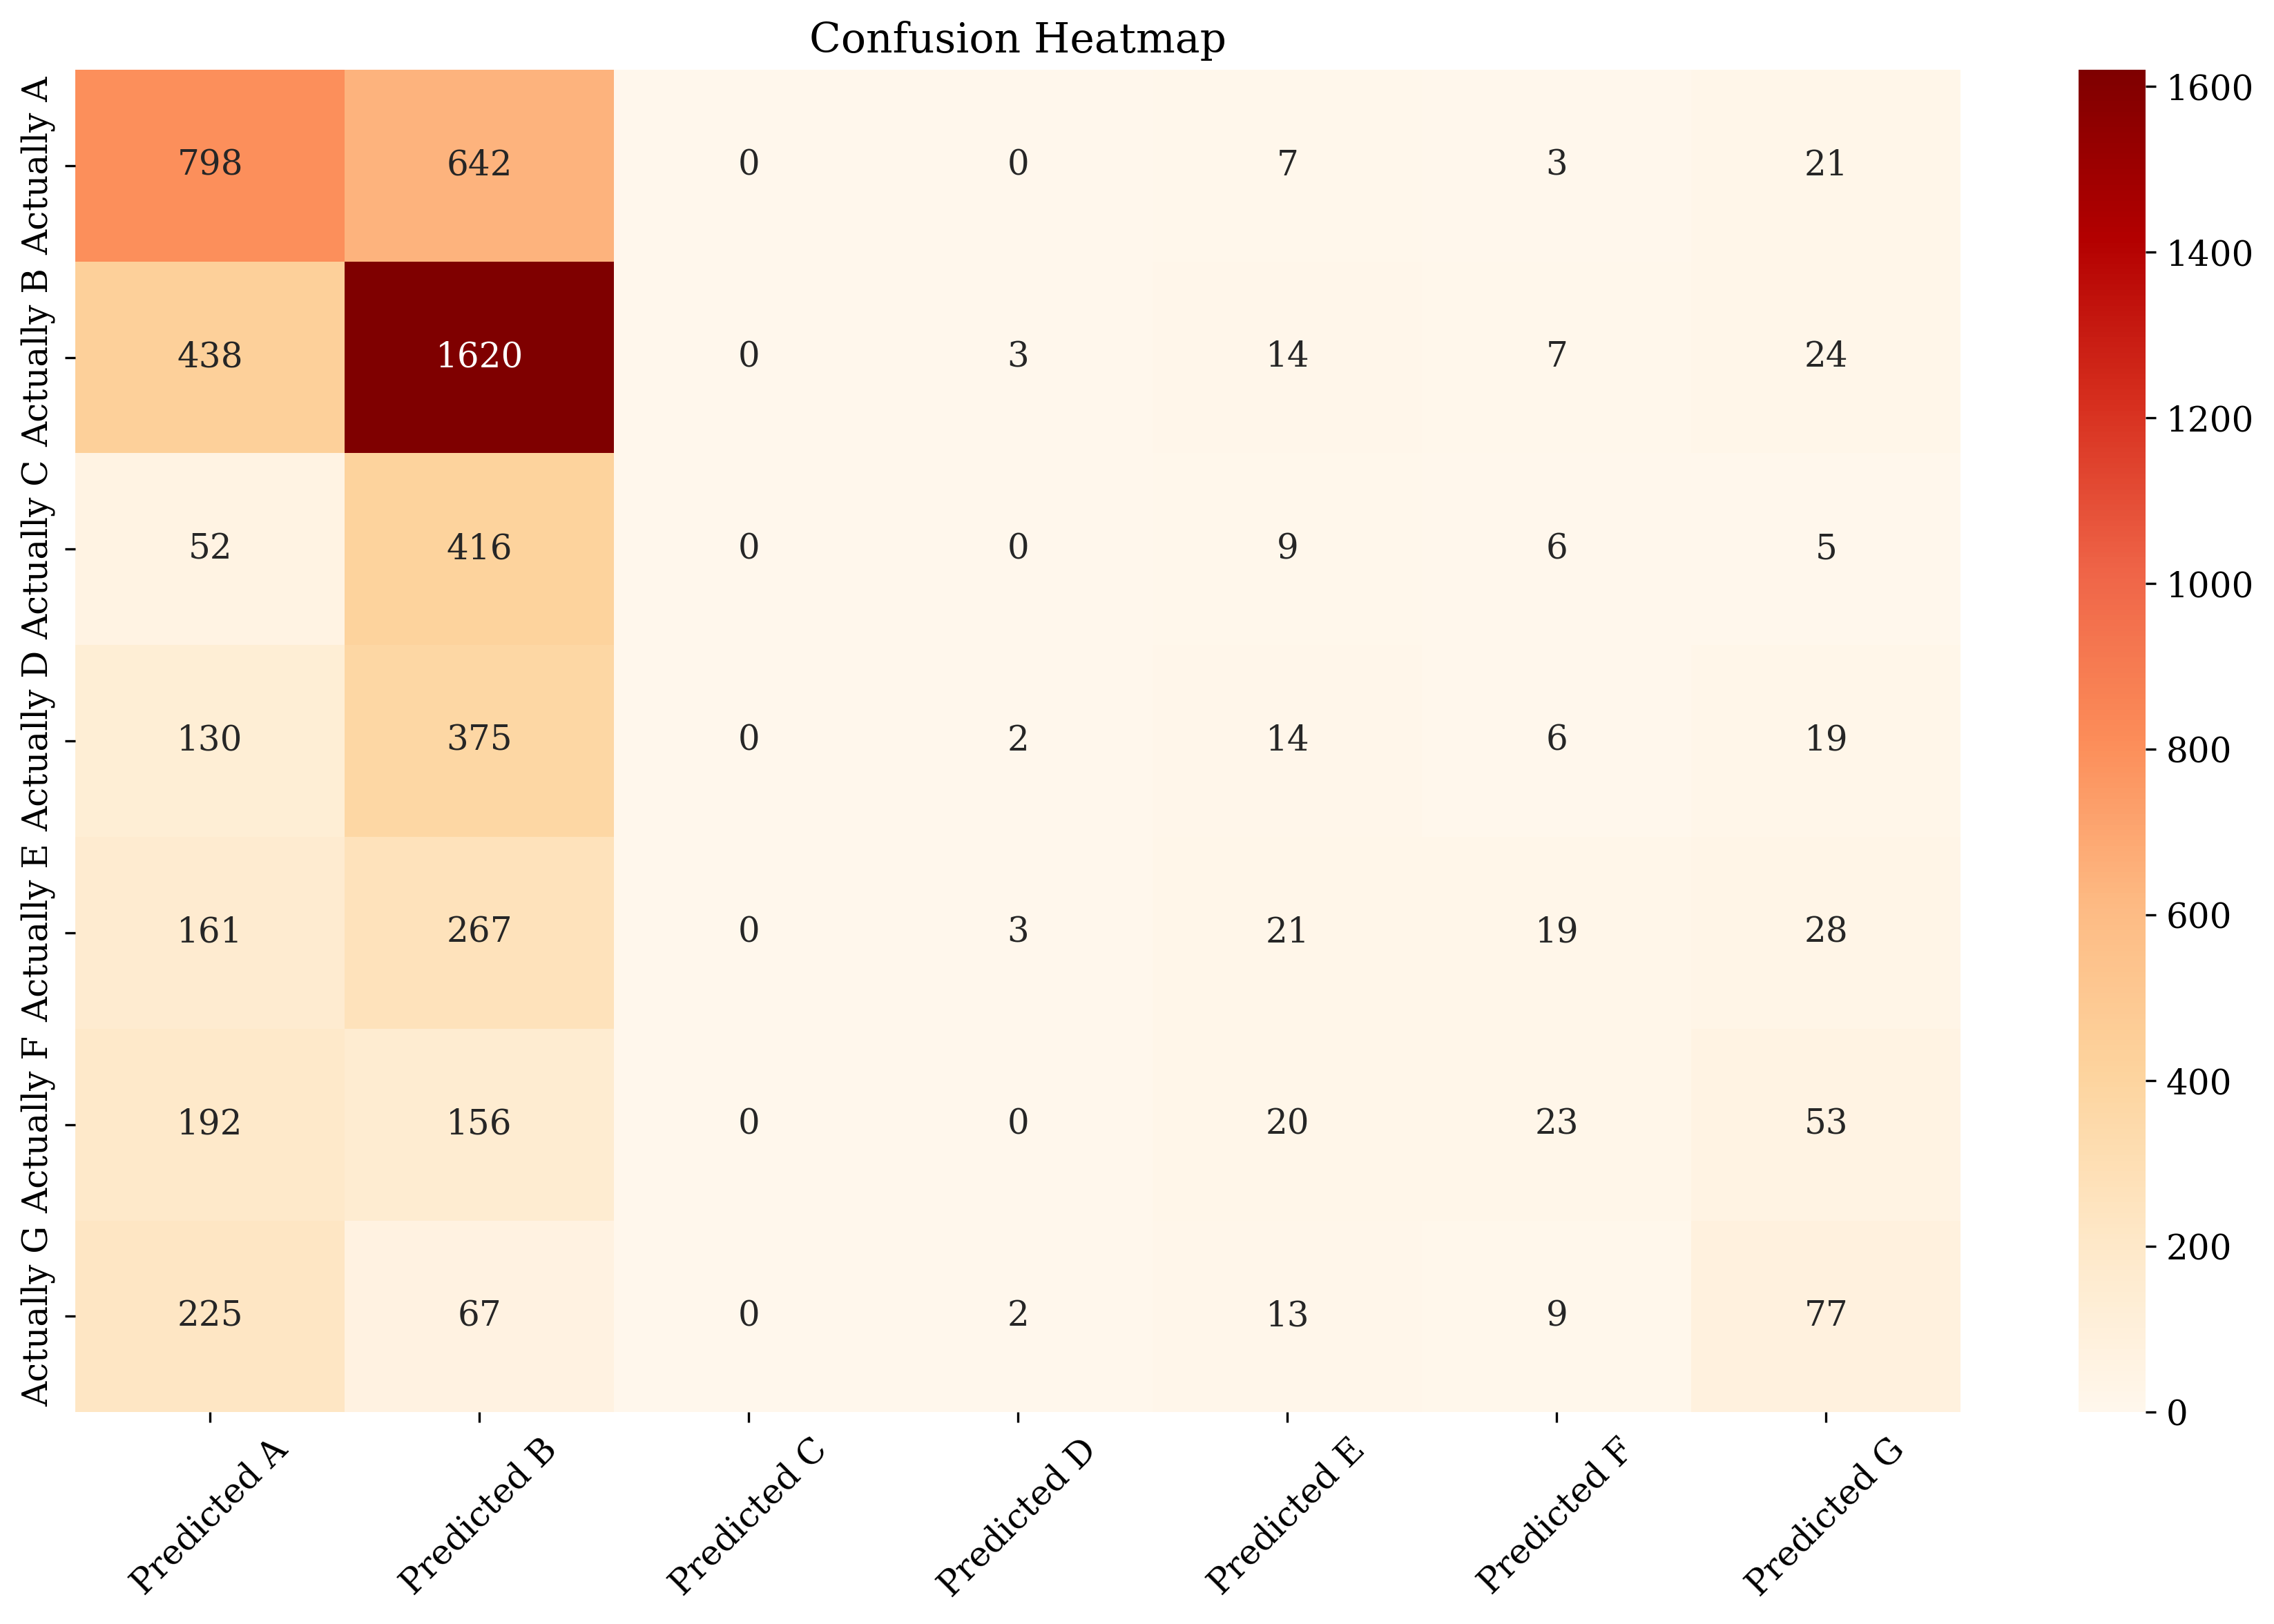

              precision    recall  f1-score   support

           A       0.40      0.54      0.46      1471
           B       0.46      0.77      0.57      2106
           C       0.00      0.00      0.00       488
           D       0.20      0.00      0.01       546
           E       0.21      0.04      0.07       499
           F       0.32      0.05      0.09       444
           G       0.34      0.20      0.25       393

    accuracy                           0.43      5947
   macro avg       0.28      0.23      0.21      5947
weighted avg       0.34      0.43      0.35      5947



/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ejb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
model_utils.PlotConfusionMatrix(fittedgrid.best_estimator_, X_test, y_test)